In [1]:
# Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def subtitle_to_df(subtitle_file):
    # Read the file
    with open(subtitle_file) as file:
        subtitle_raw = file.read()
        subtitle_block = subtitle_raw.split('\n\n')
    
    # Extract with list comprehension, generating nested list
    line_each = [ x.split('\n', 2) for x in subtitle_block ]
    
    # Turn nested list into Pandas DataFrame
    df = pd.DataFrame(line_each, columns = ['Counter', 'Time', 'Text'])
    
    # Drop None
    df = df.dropna()
    
    # Trime time to only take the time to appear excluding milliseconds
    df['Time'] = df['Time'].apply(lambda x: x.split(',')[0])
    
    # Remove \n in text column
    df['Text'] = df['Text'].apply(lambda x: x.replace('\n', ''))
    
    # Lowercase them all to make query easier
    df['Text'] = df['Text'].apply(lambda x: x.lower())
    
    # Return the DataFrame
    return df

In [3]:
def combinator(folder):
    # Create DataFrame placeholder prior appending
    df_all = pd.DataFrame()
    
    # Create counter for episode column, start at 1
    n = 1
    
    # Read every files in 'folder'
    for root, dirs, files in os.walk(folder):
        
        # By default, things aren't sorted, so we need to sort
        for file in sorted(files):
            
            # Join root with file string
            file_path = os.path.join(root, file)
            
            # Run the function to turn raw data into df
            df_each = subtitle_to_df(file_path)
            
            # Place the episode number in new Episode column
            df_each['Episode'] = n
            
            # Increase the counter by 1
            n += 1
            
            # Append into final DataFrame
            df_all = df_all.append(df_each, ignore_index = False)
    
    # Return data with re-arranged column
    return df_all[['Episode', 'Counter', 'Time', 'Text']]

In [4]:
# Read raw input files, save as csv
combinator('store/srt/').to_csv('data/Dr. STONE.csv', index = False)

# Read from CSV
df = pd.read_csv('data/Dr. STONE.csv')

# Label the data
df['Science'] = df['Text'].apply(lambda x: 'Pull' if 'science' in x else 'Drop')

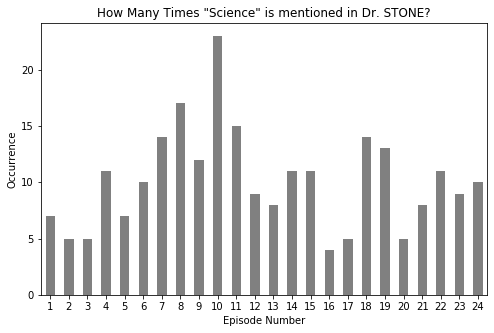

In [5]:
# Make plot bigger
plt.figure(figsize = (8,5))

# Method chaining to query, groupby, calculate size per group, and to plot
(df
 .query(' Science == "Pull" ')
 .groupby('Episode')
 .size()
 .plot(kind = 'bar', color = 'gray')
)

# Aesthetics
plt.ylabel('Occurrence')
plt.xlabel('Episode Number')
plt.title('How Many Times "Science" is mentioned in Dr. STONE?')
plt.xticks(rotation = 'horizontal')

# Save the plot, uncomment to actually save it
plt.savefig('charts/Dr. STONE - first plot.png', 
            format = 'png', 
            dpi = 300, 
            bbox_inches = 'tight')

# Render the plot
plt.show()

In [6]:
# Relationship between 'senku' and science?

# Label the data
df['Senku'] = df['Text'].apply(lambda x: 'Pull' if 'senku' in x else 'Drop')

# Combine pull labels in Science in Senku column, pull them all with OR operator
ss = df.query(' Science == "Pull" or Senku == "Pull" ')

# Replace "Drop" with NaN so .groupby().count() would exclude that
ss_dropMarked = ss.replace('Drop', np.NaN)

# Perform grouping and count occurrence
ss_grouped = ss_dropMarked.groupby('Episode').count().reset_index()

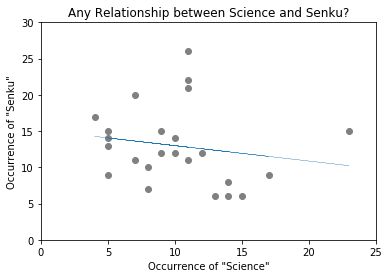

In [7]:
# DataFrame.Series into x_ and y_ np.array
x_ = ss_grouped['Science'].to_numpy()
y_ = ss_grouped['Senku'].to_numpy()

# Plot with matplotlib
plt.plot(x_, y_, marker = 'o', linestyle = '', color = 'gray')

# Calculate linear equation with np.polyfit()
m, b = np.polyfit(x_, y_, 1)

# Add the line from linear equation
plt.plot(x_, m*x_ + b, linewidth = .2)

# Customization
plt.title('Any Relationship between Science and Senku?')
plt.xlabel('Occurrence of "Science"')
plt.ylabel('Occurrence of "Senku"')
plt.yticks(range(0, 31, 5))
plt.xticks(range(0, 26, 5))

# Save plot
#plt.savefig('charts/Dr. STONE - rel plot.png', 
            dpi = 300, format = 'png', bbox_inches = 'tight')

# Call plot
plt.show()